<a href="https://colab.research.google.com/github/aelmah/Energy_forecasting/blob/main/Energy_Consumption_Forecasting_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Data Acquisition and Preprocessing**

We start by downloading the dataset and creating cyclical time features. This is crucial because standard integers (0-23 for hours) don't represent the continuous nature of time, which can confuse the LSTM's forget gate.

In [ ]:
import kagglehub
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, Layer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- 1. Load Data ---
path = kagglehub.dataset_download("robikscube/hourly-energy-consumption")
df = pd.read_csv(os.path.join(path, "AEP_hourly.csv"), index_col='Datetime', parse_dates=True).sort_index()

# --- 2. Feature Engineering (Paper Innovation) ---
# Create cyclical features for hours (24h) and days (7d)
df['hour_sin'] = np.sin(2 * np.pi * df.index.hour / 24.0)
df['hour_cos'] = np.cos(2 * np.pi * df.index.hour / 24.0)
df['day_sin'] = np.sin(2 * np.pi * df.index.dayofweek / 7.0)
df['day_cos'] = np.cos(2 * np.pi * df.index.dayofweek / 7.0)

features = ['AEP_MW', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos']
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])

# --- 3. Sequence Creation (24h Window -> 24h Prediction) ---
def create_sequences(data, window=24, horizon=24):
    X, y = [], []
    for i in range(len(data) - window - horizon):
        X.append(data[i:i+window, :])
        y.append(data[i+window:i+window+horizon, 0])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

Using Colab cache for faster access to the 'hourly-energy-consumption' dataset.


**2. Defining the Attention Layer**

Standard LSTMs treat all 24 input hours with equal weight. We will build a custom Self-Attention layer that forces the model to "pay attention" to the specific hours that historically trigger peak demand.

In [ ]:
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        # Alignment scores
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1) # Attention weights
        output = x * a
        return tf.keras.backend.sum(output, axis=1)

**3. The Model Architecture: Bi-LSTM + Attention**

By using a Bidirectional LSTM, the model learns patterns by looking at the sequence both forward and backward, which is vital for identifying the "build-up" to a peak.

In [ ]:
# --- 4. Custom Attention Layer ---
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1) # Attention weights
        output = x * a
        return tf.keras.backend.sum(output, axis=1)

# --- 5. Build and Train Model ---
inputs = Input(shape=(24, 5))
x = Bidirectional(LSTM(128, return_sequences=True))(inputs) # Forward/Backward context
x = Dropout(0.2)(x)
x = AttentionLayer()(x) # Dynamic weight assignment
x = Dense(64, activation='relu')(x)
outputs = Dense(24)(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='huber') # Huber is robust to peak outliers

# Early stopping to prevent overfitting
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
model.fit(X_train, y_train, epochs=30, batch_size=64, validation_split=0.1, callbacks=[callback])

Epoch 1/30
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 120s 85ms/step - loss: 0.0067 - val_loss: 0.0016
Epoch 2/30
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 113s 82ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 3/30
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 114s 83ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 4/30
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 113s 83ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 5/30
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 114s 83ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 6/30
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 115s 84ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 7/30
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 114s 83ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 8/30
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 115s 84ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 9/30
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 113s 83ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 10/30
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 114s 83ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 11/30
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 114s 83ms/step - loss: 0.0011 - val_loss: 0.00

**4. Evaluation and Visualization**

we calculate the MAPE (Mean Absolute Percentage Error) and visualize the results.

758/758 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step
Final Model MAPE: 3.74%


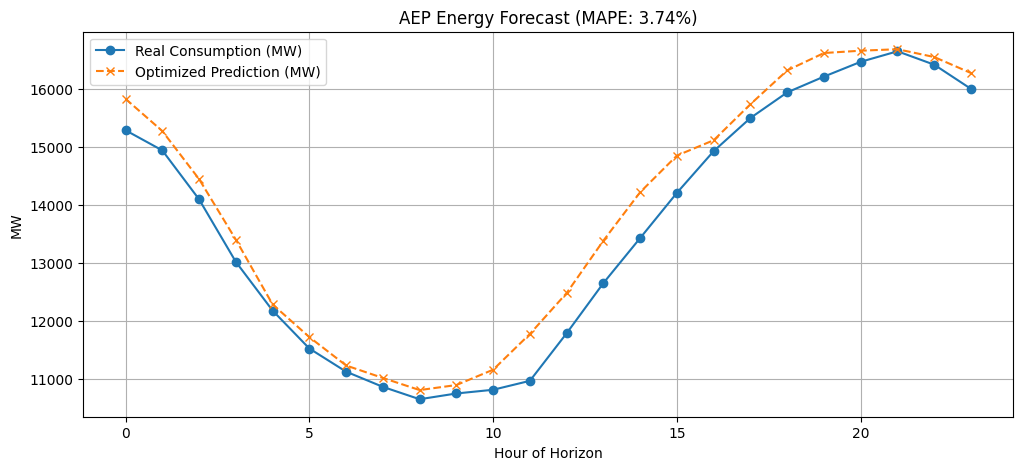

In [ ]:
# --- 6. Predictions & Visuals ---
preds_scaled = model.predict(X_test)

def inverse_rescale(scaled_val, scaler):
    # Flatten to (N, 1), fill other 4 columns with zeros to match scaler shape
    flat_val = scaled_val.reshape(-1, 1)
    dummy = np.zeros((len(flat_val), 5))
    dummy[:, 0] = flat_val[:, 0]
    inv = scaler.inverse_transform(dummy)[:, 0]
    return inv.reshape(scaled_val.shape)

preds_mw = inverse_rescale(preds_scaled, scaler)
actual_mw = inverse_rescale(y_test, scaler)

# Final Metric
mape = np.mean(np.abs((actual_mw - preds_mw) / actual_mw)) * 100
print(f"Final Model MAPE: {mape:.2f}%")

# Plot a random sample from the test set
idx = -100 # Change this to see different days
plt.figure(figsize=(12, 5))
plt.plot(actual_mw[idx], label="Real Consumption (MW)", marker='o')
plt.plot(preds_mw[idx], label="Optimized Prediction (MW)", linestyle='--', marker='x')
plt.title(f"AEP Energy Forecast (MAPE: {mape:.2f}%)")
plt.xlabel("Hour of Horizon")
plt.ylabel("MW")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Identify indices where actual consumption is in the top 10% (Peaks)
peak_threshold = np.percentile(actual_mw, 90)
peak_mask = actual_mw > peak_threshold

# Calculate MAPE specifically for those peak periods
peak_mape = np.mean(np.abs((actual_mw[peak_mask] - preds_mw[peak_mask]) / actual_mw[peak_mask])) * 100
base_mape = np.mean(np.abs((actual_mw[~peak_mask] - preds_mw[~peak_mask]) / actual_mw[~peak_mask])) * 100

print(f"Global MAPE: {mape:.2f}%")
print(f"Peak-Load MAPE (Top 10%): {peak_mape:.2f}%")
print(f"Base-Load MAPE: {base_mape:.2f}%")

Global MAPE: 3.74%
Peak-Load MAPE (Top 10%): 3.82%
Base-Load MAPE: 3.73%
